# Rapid prototyping for custom ODE classes

## Example: Reaction diffusion system (Gray-Scott model)

*Note that this little example of a reaction diffusion system is based on the* [post by Karl Sims](https://www.karlsims.com/rd.html) *and the related work by* [Sebatian Lague](https://www.youtube.com/watch?v=kzwT3wQWAHE). *Thank you both for the inspiration!*

Imagine two chemicals or species $A$ and $B$ which are dispersed in another medium. $A$ is added at a given feed rate $f$ but it can maximally reach a concentration of $A=1$. A reaction converts one $A$ into $B$ in the presence of two other $B$ (i.e. reaction term $c_A c_B^2$). $B$ is continuously removed with a given kill rate $k$ until it reaches $B=0$. Both species are also diffusing within the solution with a given chemical diffusivity $D_A$ and $D_B$ respectively.

The coupled behaviour of both species can be formulated in terms of the coupled PDEs:

$$\frac{\partial c_A}{\partial t}=\nabla\cdot\left(D_A\nabla c_A\right) - c_A c_B^2 + f(1-c_A),$$

$$\frac{\partial c_B}{\partial t}=\nabla\cdot\left(D_B\nabla c_B\right) + c_A c_B^2 + k c_B.$$

A variation of the input parameters (feed rate, kill rate and the ratio of diffusivities) leads to a wide range of different results. Let's explore how surprisingly complex and dynamic the emerging behaviours can be given such simple rules...

## Defining the custom ODE class

**voxelsss** comes with predefined ODE classes for phase evolution and reaction-diffusion system but we can also use the modular concept to prototype new systems of PDEs. This generally involves:
- Formulation of the analytical right-hand side in sympy logic
- Discretisation of the rhs into an ODE system using finite differences
- Defining the expected order of convergence
- Testing if the implementation is correct and achieves the expected order of convergence before simulating the material behaviour.

For our chosen exmple - the Gray-Scott model:
- We define the for parameters $D_A$, $D_B$, $f$ and $k$ as input paramters. Additionally, the interaction term is set to $c_A c_B^2$ by default but can also be given as an input function.
- The ``CoupledReactionDiffusion`` class inherits from the ``SpectralODE`` class because we want to use the ``pseudo_spectral_IMEX`` timestepper later on. Therefore, we need to define the spectral factor which is defined as the factor in front of the laplacian term multiplied by the squared wave vectors ``k``.
- The ``interaction`` term takes ``lib`` as an additional input argument to make it compatible with both the analytical and numerical evaluation of the right-hand side. In the first case we input ``sympy`` as the library and, in the second case, the backend library (``torch``/``jax``) is used.

In [1]:
from dataclasses import dataclass, field
from typing import Any, Callable
import sympy as sp
import sympy.vector as spv
from voxelsss.problem_definition import SpectralODE
from voxelsss.voxelgrid import VoxelGrid

@dataclass
class CoupledReactionDiffusion(SpectralODE):
    vg: VoxelGrid
    D_A: float = 1.0
    D_B: float = 0.5
    feed: float = 0.055
    kill: float = 0.117
    interaction: Callable | None = None
    _spectral_factor: Any = field(init=False, repr=False)
    
    def __post_init__(self):
        """Precompute factors required by the spectral solver."""
        k_squared = self.vg.rfft_k_squared()
        self._spectral_factor = max(self.D_A, self.D_B) * k_squared
        if self.interaction is None:
            self.interaction = lambda u, lib=None: u[0] * u[1]**2
    
    @property
    def order(self):
        return 2

    @property
    def spectral_factor(self):
        return self._spectral_factor

    def pad_boundary_conditions(self, u):
        return self.vg.pad_periodic_BC(u)

    def _eval_interaction(self, u, lib):
        """Evaluate interaction term"""
        try:
            return self.interaction(u, lib)
        except TypeError:
            return self.interaction(u)

    def rhs_analytic(self, u, t):
        interaction = self._eval_interaction(u, sp)
        dc_A = self.D_A*spv.laplacian(u[0]) - interaction + self.feed * (1-u[0])
        dc_B = self.D_B*spv.laplacian(u[1]) + interaction - self.kill * u[1]
        return (dc_A, dc_B)

    def rhs(self, u, t):
        r"""Two-component reaction-diffusion system
        
        Use batch channels for multiple species:
        - Species A with concentration c_A = u[0]
        - Species B with concentration c_B = u[1]

        Args:
            u (array-like): species
            t (float): Current time.

        Returns:
            Backend array of the same shape as ``u`` containing ``du/dt``.
        """
        interaction = self._eval_interaction(u, self.vg.lib)
        u_pad = self.vg.pad_periodic_BC(u)
        laplace = self.vg.calc_laplace(u_pad)
        dc_A = self.D_A*laplace[0] - interaction + self.feed * (1-u[0])
        dc_B = self.D_B*laplace[1] + interaction - self.kill * u[1]
        return self.vg.lib.stack((dc_A, dc_B), 0)

## Testing the right-hand side

Before running simulations, we should test whether the implementation of our equations is correct and achieves the expected order of convergence or not.
Let's define the test functions, i.e. two initial fields for $c_A$ and $c_B$ which **must comply with the boundary conditions** of our ODE, i.e. periodicity in this case.

In [2]:
import sympy as sp
import sympy.vector as spv

CS = spv.CoordSys3D('CS')
test_funs = (0.5 + 0.3 * sp.cos(4*sp.pi*CS.x) * sp.cos(4*sp.pi*CS.y)**3,
             0.4 + 0.1 * sp.sin(2*sp.pi*CS.x) * sp.cos(4*sp.pi*CS.z) )

The convergence test for ODE right-hand sides is predefined in the ``utils.py`` file and can be imported - fully ready to be used:

In [3]:
from voxelsss.utils import rhs_convergence_test

precision = 'float64'
dx, errors, slope, order = rhs_convergence_test(
        ODE_class      = CoupledReactionDiffusion,
        problem_kwargs = {"D_A": 1.0, "D_B": 0.5},
        test_function  = test_funs,
        convention     = 'cell_center',
        dtype          = precision
    )

print(f"Grid spacing: {dx}")
print(f"Errors c_a:   {errors[0]}")
print(f"Errors c_b:   {errors[1]}")
print("Convergence rate from slope fit:", slope)
print("Expected order of convergence:  ", order)

Grid spacing: [0.125     0.0625    0.03125   0.015625  0.0078125]
Errors c_a:   [1.81181187 0.30247238 0.08655272 0.02238807 0.00564499]
Errors c_b:   [0.16207643 0.04296587 0.01090076 0.00273525 0.00068444]
Convergence rate from slope fit: [2.04084953 1.97485054]
Expected order of convergence:   2


Let's now visualise the resulting order of convergence as an error plot over the spatial discretisation $\Delta x$ with logarithmic axes.

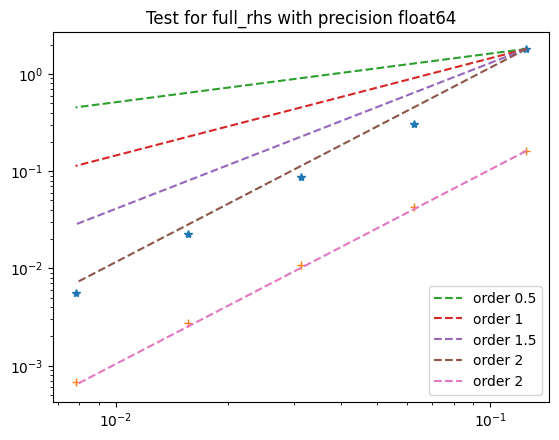

In [4]:
import matplotlib.pyplot as plt

plt.loglog(dx, errors[0],'*')
plt.loglog(dx, errors[1],'+')
plt.loglog(dx, errors[0,0]/dx[0]**0.5*dx**0.5, '--', label = 'order 0.5')
plt.loglog(dx, errors[0,0]/dx[0]*dx,'--', label = 'order 1')
plt.loglog(dx, errors[0,0]/dx[0]**1.5*dx**1.5,'--', label = 'order 1.5')
plt.loglog(dx, errors[0,0]/dx[0]**2*dx**2,'--', label = 'order 2')
plt.loglog(dx, errors[1,0]/dx[0]**2*dx**2,'--', label = 'order 2')
plt.legend()
plt.title(f'Test for full_rhs with precision {precision}')
plt.show()

Hurray! Our ``CoupledReactionDiffusion`` is correctly implemented and shows second order convergence as expected.

## Run simulations

Now that the new ODE class is fully implemented and tested, let's have some fun with simulations. In order to run simulations we
- Instantiate a VoxelFileds class
- Create two initial fields for $c_A$ and $c_B$
- Set the problem-specific input parameters
- Create a solver based on a given backend (``torch``), our ODE class and a predefined timestepper (``pseudo_spectral_IMEX``)`
- Run the solve function for a defined amount of timesteps with given $\Delta t$ and the amount of frames. Set ``verbose='plot'`` for on-the-fly visualisation and choose a custom colorbar (e.g. ``'turbo'``).

Have fun!

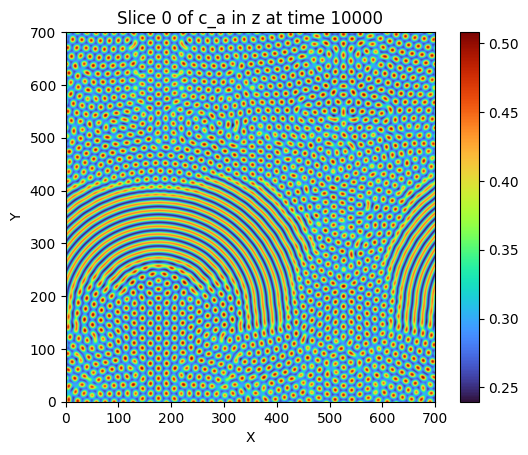

Wall time: 21.2104 s after 10000 iterations (0.0021 s/iter)
GPU-RAM currently allocated: 18.32 MB (69.21 MB reserved)
GPU-RAM maximally allocated: 46.59 MB (69.21 MB reserved)
GPU-RAM nvidia-smi current:  161 MB (161 MB max)


In [5]:
import voxelsss as vox
import numpy as np
import torch
from voxelsss.solvers import TimeDependendSolver
from voxelsss.timesteppers import pseudo_spectral_IMEX

Nx, Ny, Nz = [700, 700, 1]
vf = vox.VoxelFields((Nx, Ny, Nz), domain_size=(Nx, Ny, Nz))
vf.add_field('c_a', np.ones((Nx, Ny, Nz)))
vf.add_field('c_b')

vf.set_voxel_sphere('c_b', (Nx//4, Ny//4, Nz//2), 5, 1)
vf.set_voxel_sphere('c_b', (Nx//4, Ny//4-3, Nz//2), 5, 0)

# stripes and bubbles: D_b=0.2, feed=0.053, kill=0.1165
# rings and bubbles: D_b=0.2, feed=0.055, kill=0.11
# cells D_b=0.2, feed=0.055, kill=0.14
# corals D_b=0.5, feed=0.055, kill=0.117
# waves D_b=0.5, feed=0.012, kill=0.06
problem_kwargs = {\
    "D_A": 1.0, "D_B": 0.2,
    "feed": 0.055,
    "kill": 0.11
}
solver = TimeDependendSolver(
        vf, ('c_a', 'c_b'),
        'torch', device='cuda',
        problem_cls = CoupledReactionDiffusion,
        timestepper_fn = pseudo_spectral_IMEX,
    )
solver.solve(1, 50, 10000, problem_kwargs, verbose='plot', colormap='turbo')

As a little cherry on the cake, we can modify the interaction term between the two species to make the reaction $A\to B$ faster/slower in particular areas. For this we create a meshgrid (**carefull: this must be on the same device as the VoxelGrid in the solver**) and modify the original interaction term $c_A c_B^2$ to

$$\text{interaction} = c_A c_B^2 (1 - 0.2\cos(4 x /N_x) \cos(2 y/N_y))$$

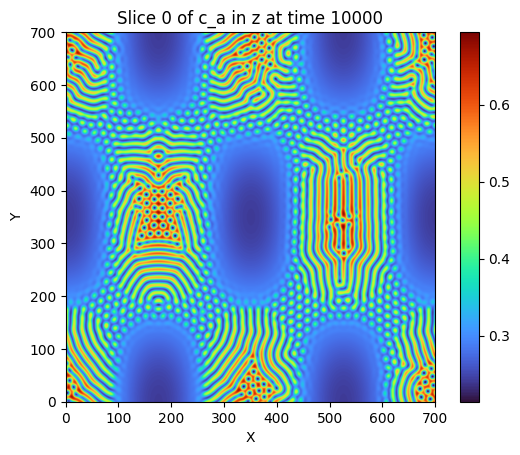

Wall time: 25.2457 s after 10000 iterations (0.0025 s/iter)
GPU-RAM currently allocated: 19.02 MB (69.21 MB reserved)
GPU-RAM maximally allocated: 47.28 MB (69.21 MB reserved)
GPU-RAM nvidia-smi current:  161 MB (161 MB max)


In [6]:
vf.add_field('c_a', np.ones((Nx, Ny, Nz)))
vf.add_field('c_b')

vf.set_voxel_sphere('c_b', (Nx//4, Ny//4, Nz//2), 5, 1)
# vf.set_voxel_sphere('c_b', (Nx//4, Ny//4-3, Nz//2), 5, 0)

axes = tuple(torch.arange(0, n, device='cuda') * vf.spacing[i] + vf.origin[i]
                     for i, n in enumerate(vf.shape))
grid = tuple(torch.meshgrid(*axes, indexing='ij'))

def interaction(u, lib):
    return u[0] * u[1]**2 * (1 - 0.2*lib.cos(4*lib.pi*grid[0]/Nx)*lib.cos(2*lib.pi*grid[1]/Ny))

problem_kwargs = {\
    "D_A": 1.0, "D_B": 0.2,
    "feed": 0.055,
    "kill": 0.11,
    "interaction": interaction}

solver = TimeDependendSolver(
        vf, ('c_a', 'c_b'),
        'torch', device='cuda',
        problem_cls = CoupledReactionDiffusion,
        timestepper_fn = pseudo_spectral_IMEX,
    )
solver.solve(1, 50, 10000, problem_kwargs, verbose='plot', colormap='turbo')

Eager to try out more? Here are some ressources of inspiring work:

- A very interactive module for the Gray Scott model has been implemented by [Karl Sims](https://www.karlsims.com/rdtool.html).
- A whole collection of scientifically relevant PDEs can be found on [visualpde](https://visualpde.com/explore.html).